In [33]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import cv2
# Root directory of the project
import pdb
ROOT_DIR = os.path.abspath("Mask_RCNN")
sys.path.append(ROOT_DIR) 

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
#IMAGE_DIR = os.path.join(ROOT_DIR, "images")

in_path = 'examples/inputs/dog1.png'
out_path = 'out2.png'

In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Processing 1 images
image                    shape: (713, 1144, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1144.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


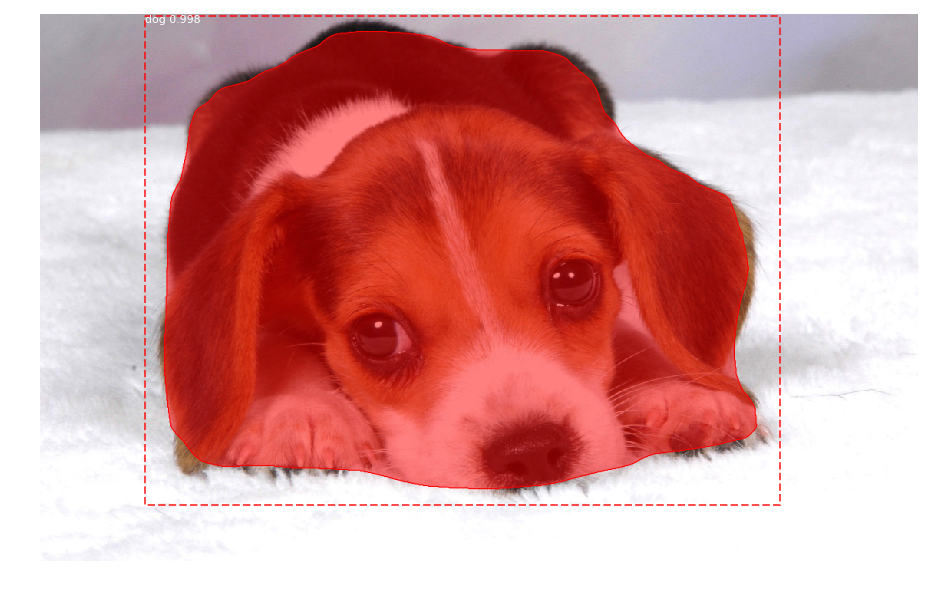

In [6]:
# Load a random image from the images folder
file_names = in_path
image = skimage.io.imread(file_names)[:,:,:3]

# Run detection
results = model.detect([image], verbose=1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [34]:
contour = find_contours(results[0]['masks'][:,:,0], 0.5)
pts = np.fliplr(contour[0].astype(int))
croped = cv2.resize(image.copy(),image.shape[:2][::-1])

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
dst = cv2.bitwise_and(croped, croped, mask=mask)
white_bg = True
if white_bg:
    bg = np.ones_like(croped, np.uint8) * 255
    bg = cv2.bitwise_not(bg,bg, mask=mask)
else:
    bg = np.zeros_like(croped, np.uint8)
dst2 = bg+ dst
plt.figure(figsize = (15, 15))
#plt.imshow(dst2, cmap=None) 

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

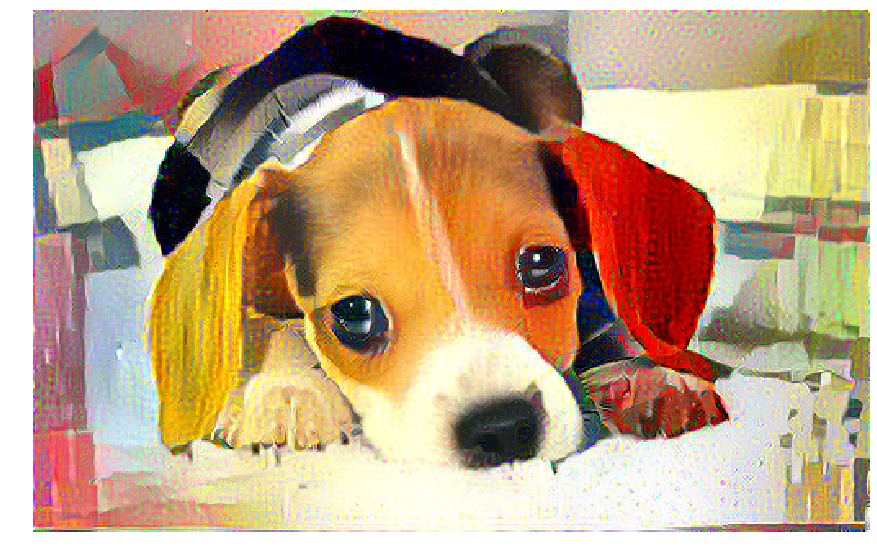

In [35]:
styled_img = cv2.imread(out_path)
plt.figure(figsize = (15, 15))
plt.axis('off')
plt.imshow(cv2.cvtColor(styled_img, cv2.COLOR_BGR2RGB), cmap=None) 

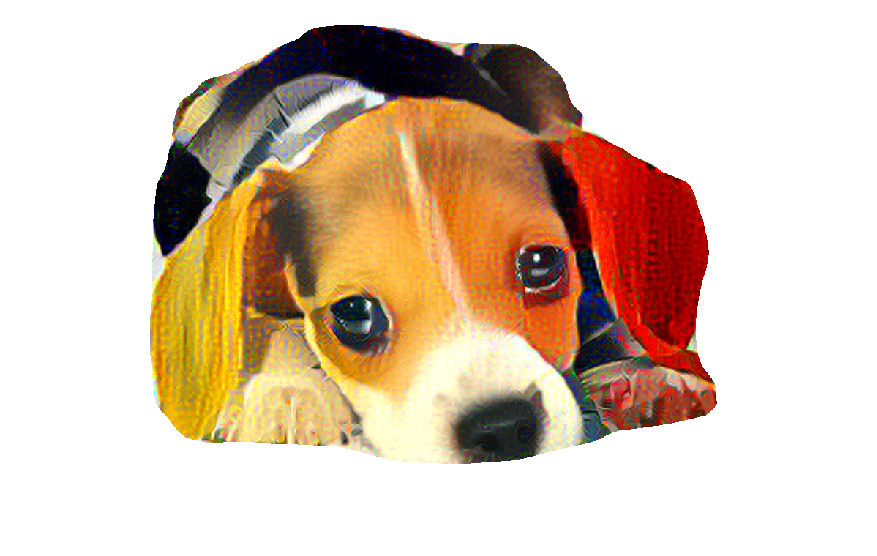

In [36]:
croped = cv2.resize(styled_img.copy(),image.shape[:2][::-1])

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
dst = cv2.bitwise_and(croped, croped, mask=mask)
white_bg = True
if white_bg:
    bg = np.ones_like(croped, np.uint8) * 255
    bg = cv2.bitwise_not(bg,bg, mask=mask)
else:
    bg = np.zeros_like(croped, np.uint8)
    
foreground = bg+ dst
plt.figure(figsize = (15, 15))
plt.axis('off')
plt.imshow(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB), cmap=None) 


In [37]:
ori_bg = image.copy()
background = cv2.drawContours(ori_bg, [pts], -1, (0, 0, 0), -1, cv2.LINE_AA)
plt.figure(figsize = (15, 15))
#plt.imshow(background, cmap=None) 

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [38]:
### blending without alpha mask
ori_bg = image.copy()
foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB).astype(float)
background = background.astype(float)
merged = foreground.copy()
for x in range(merged.shape[0]):
    for y in range(merged.shape[1]):
        if max(merged[x][y]) == 0:
            merged[x][y] = background[x][y]
plt.figure(figsize = (15, 15))
#plt.imshow(merged.astype(np.uint8), cmap=None) 


<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

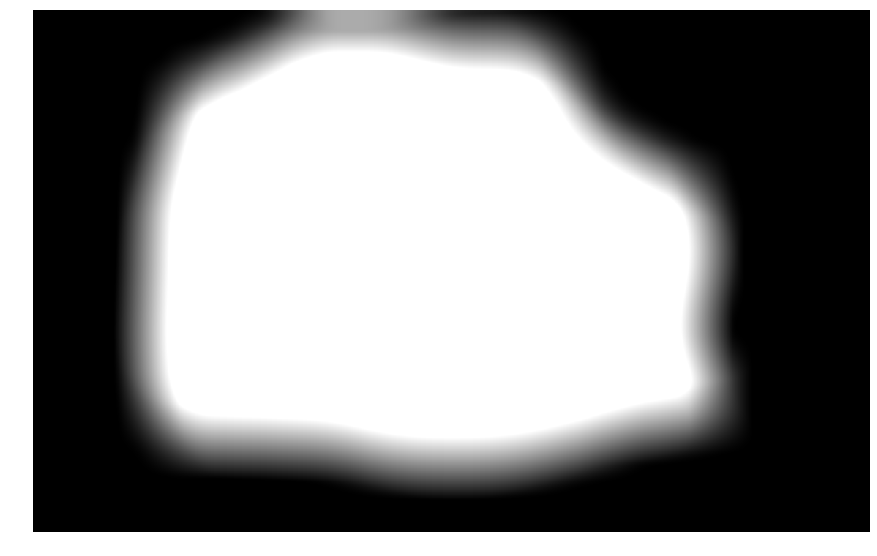

In [39]:
### blending with alpha mask
mask = np.zeros(croped.shape[:2], np.uint8)
mask = cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
mask = cv2.GaussianBlur(mask,(101,101),1000,1000)
plt.figure(figsize = (15, 15))
plt.axis('off')
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)) 

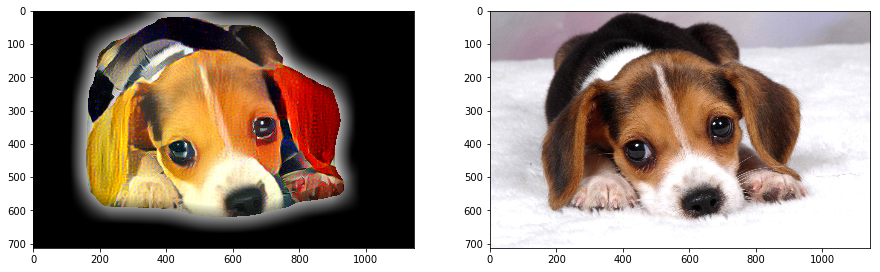

In [40]:
alpha = (mask.astype(float)/255)[:, :, None]
#blended = (alpha) * merged + (1-alpha)*merged
#mask = np.zeros(croped.shape[:2], np.uint8)
#cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

foreground = alpha*merged
background = cv2.drawContours(background, [pts], -1, (0, 0, 0), -1, cv2.LINE_AA)
f, axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(foreground.astype(np.uint8), cmap=None)
axs[1].imshow(image.copy().astype(np.uint8), cmap=None)


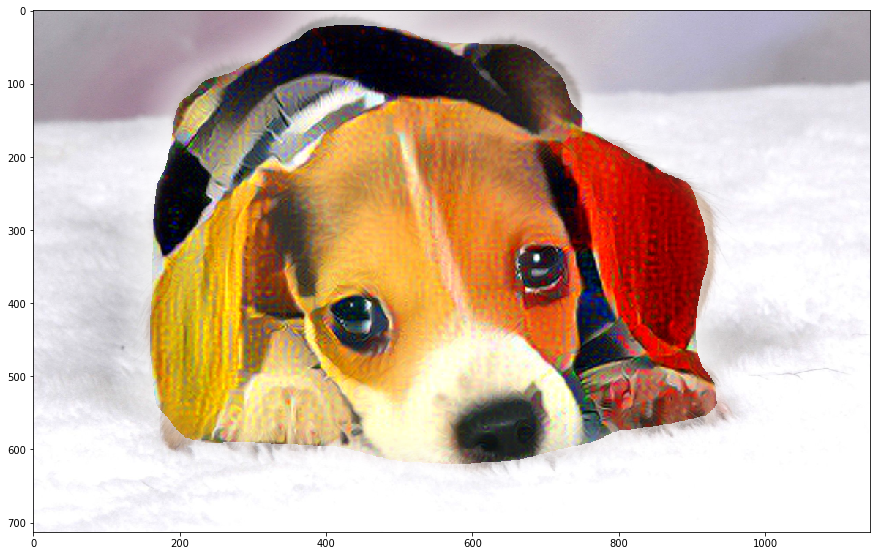

In [41]:
foreground = alpha*merged
background = (1-alpha)*image
blend = foreground + background
plt.figure(figsize = (15, 15))
plt.imshow(blend.astype(np.uint8), cmap=None)